In [58]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [59]:
# Load the training data (FD001)
col_names = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
all_columns = col_names + sensor_cols

In [60]:
train_df = pd.read_csv('H:\\extion project\\data set\\CMaps\\train_FD001.txt', sep=' ', header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)  # drop empty columns at end
train_df.columns = all_columns

In [61]:
# Show the first few rows
print("\nSample rows:")
print(train_df.head())



Sample rows:
   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1               1       -0.0007       -0.0004         100.0   
1            1               2        0.0019       -0.0003         100.0   
2            1               3       -0.0043        0.0003         100.0   
3            1               4        0.0007        0.0000         100.0   
4            1               5       -0.0019       -0.0002         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0    518.67    641.82   1589.70   1400.60     14.62  ...     521.66   
1    518.67    642.15   1591.82   1403.14     14.62  ...     522.28   
2    518.67    642.35   1587.99   1404.20     14.62  ...     522.42   
3    518.67    642.35   1582.79   1401.87     14.62  ...     522.86   
4    518.67    642.37   1582.85   1406.22     14.62  ...     522.19   

   sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0    2388.02    8138.62     8.4

In [62]:
# Check dataset shape and nulls
print("\nShape:", train_df.shape)
print("\nMissing values:")
print(train_df.isnull().sum())


Shape: (20631, 26)

Missing values:
unit_number       0
time_in_cycles    0
op_setting_1      0
op_setting_2      0
op_setting_3      0
sensor_1          0
sensor_2          0
sensor_3          0
sensor_4          0
sensor_5          0
sensor_6          0
sensor_7          0
sensor_8          0
sensor_9          0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_15         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
dtype: int64


In [63]:
# Step 2: Add Remaining Useful Life (RUL) column
# For each engine, find max cycle, subtract current cycle
rul_df = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_df.columns = ['unit_number', 'max_cycle']
train_df = train_df.merge(rul_df, on='unit_number')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_in_cycles']
train_df.drop('max_cycle', axis=1, inplace=True)


In [89]:
data = train_df.copy()  # ✅ Save original data to use later


In [64]:

print("\nWith RUL column:")
print(train_df[['unit_number', 'time_in_cycles', 'RUL']].head())


With RUL column:
   unit_number  time_in_cycles  RUL
0            1               1  191
1            1               2  190
2            1               3  189
3            1               4  188
4            1               5  187


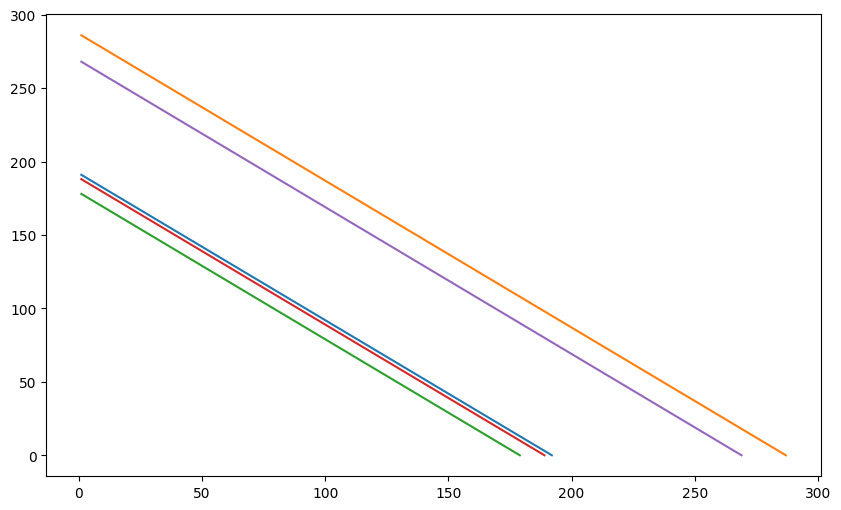

In [65]:
# Step 3: EDA - Plot RUL for few engines
plt.figure(figsize=(10, 6))
for unit in train_df['unit_number'].unique()[:5]:
    temp_df = train_df[train_df['unit_number'] == unit]
    plt.plot(temp_df['time_in_cycles'], temp_df['RUL'], label=f'Engine {unit}')

C:\Users\SHIVANSHU SRIVASTAVA\AppData\Local\Temp\ipykernel_25036\1639325166.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


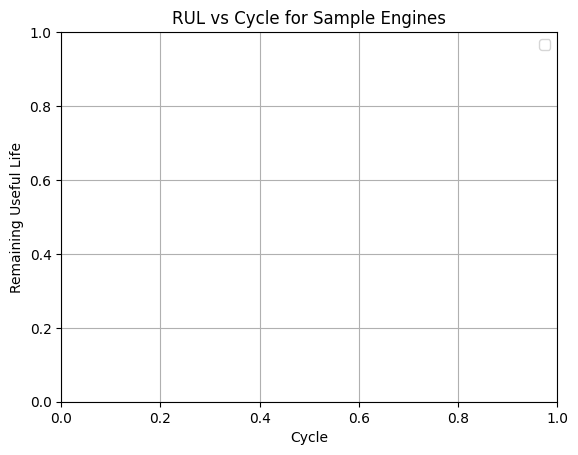

In [66]:
plt.xlabel('Cycle')
plt.ylabel('Remaining Useful Life')
plt.title('RUL vs Cycle for Sample Engines')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Optional: Plot sensor trends for engine 1
engine_1 = train_df[train_df['unit_number'] == 1]
sensor_to_plot = ['sensor_2', 'sensor_3', 'sensor_4']


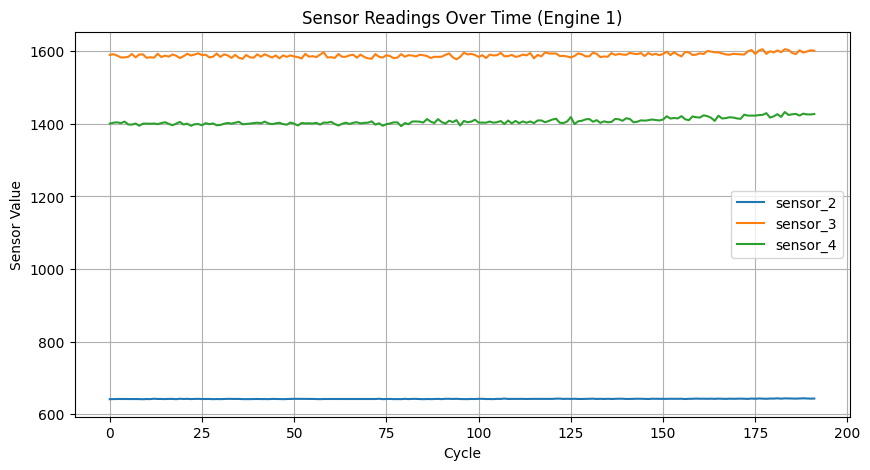

In [68]:
engine_1[sensor_to_plot].plot(figsize=(10, 5))
plt.title('Sensor Readings Over Time (Engine 1)')
plt.xlabel('Cycle')
plt.ylabel('Sensor Value')
plt.grid(True)
plt.show()


In [69]:
# Drop uninformative or highly correlated sensors
drop_cols = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
train_df.drop(columns=drop_cols, inplace=True)

In [70]:
# Features and target
feature_cols = [col for col in train_df.columns if col.startswith('op_setting') or col.startswith('sensor_')]
X = train_df[feature_cols]
y = train_df['RUL']

In [71]:
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [85]:
data = train_df.copy()  # ✅ Save original data to use later


In [93]:
# Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from sklearn.model_selection import train_test_split

# Keep X and y as DataFrames/Series to preserve index
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Ensure X_test is a DataFrame (if not already)
if isinstance(X, pd.DataFrame):
    X_test_df = X_test.copy()
else:
    X_test_df = pd.DataFrame(X_test, columns=X.columns)


In [92]:
# ========== Train Random Forest ==========
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [94]:
# Predict and evaluate
y_pred = rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

C:\Users\SHIVANSHU SRIVASTAVA\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(



Random Forest MAE: 101.63
Random Forest RMSE: 121.81


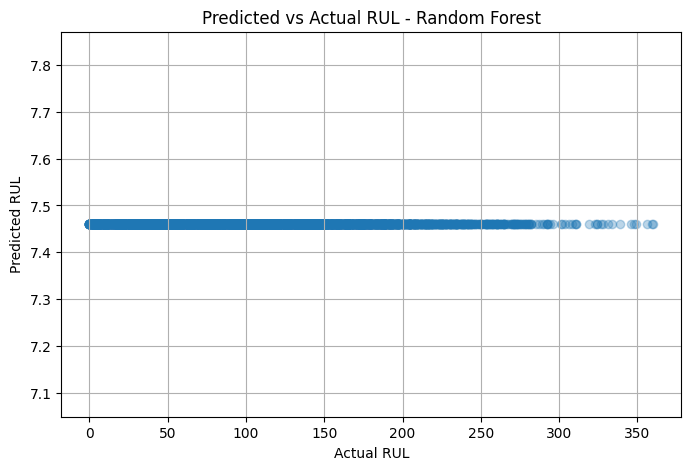

In [95]:
print(f"\nRandom Forest MAE: {mae:.2f}")
print(f"Random Forest RMSE: {rmse:.2f}")

# ========== Plot Predicted vs Actual RUL ==========
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL - Random Forest")
plt.grid(True)
plt.show()

In [96]:


# Import XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Create and train the model
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")


XGBoost MAE: 29.62
XGBoost RMSE: 41.39


In [97]:
test_df = data.loc[X_test.index].copy()


In [98]:
threshold = 20

alerts = pd.DataFrame({
    'unit_number': test_df['unit_number'],
    'cycle': test_df['time_in_cycles'],
    'predicted_RUL': y_pred_xgb
})

alerts['maintenance_alert'] = alerts['predicted_RUL'] < threshold
alerts_triggered = alerts[alerts['maintenance_alert'] == True]

print("🔔 Maintenance Alerts Triggered:")
display(alerts_triggered.sort_values(by='unit_number'))


🔔 Maintenance Alerts Triggered:


,unit_number,cycle,predicted_RUL,maintenance_alert
180,1,181,17.751701,True
474,2,283,5.306546,True
460,2,269,15.572905,True
476,2,285,5.283626,True
466,2,275,12.990482,True
...,...,...,...,...
20629,100,199,6.393981,True
20619,100,189,10.764320,True
20627,100,197,5.232345,True
20621,100,191,6.183963,True


In [100]:
# Set a threshold for RUL to trigger alerts
threshold = 20  # You can adjust this based on business needs

# Create alerts for units with RUL < threshold
alerts = pd.DataFrame({
    'unit_number': test_df['unit_number'],
    'cycle': test_df['time_in_cycles'],
    'predicted_RUL': y_pred_xgb
})

# Flag alerts
alerts['maintenance_alert'] = alerts['predicted_RUL'] < threshold

# Show only alerts
alerts_triggered = alerts[alerts['maintenance_alert'] == True]

print("🔔 Maintenance Alerts Triggered:")
display(alerts_triggered.sort_values(by='unit_number'))


🔔 Maintenance Alerts Triggered:


,unit_number,cycle,predicted_RUL,maintenance_alert
180,1,181,17.751701,True
474,2,283,5.306546,True
460,2,269,15.572905,True
476,2,285,5.283626,True
466,2,275,12.990482,True
...,...,...,...,...
20629,100,199,6.393981,True
20619,100,189,10.764320,True
20627,100,197,5.232345,True
20621,100,191,6.183963,True


In [101]:
alerts.head()


,unit_number,cycle,predicted_RUL,maintenance_alert
13857,69,227,126.463005,False
1710,8,148,10.941011,True
9278,48,14,176.475098,False
10786,54,257,2.352574,True
19709,96,158,134.146301,False


In [102]:
alerts.to_csv("alerts.csv", index=False)


In [103]:
import pandas as pd
pd.read_csv("alerts.csv").head()


,unit_number,cycle,predicted_RUL,maintenance_alert
0,69,227,126.463005,False
1,8,148,10.941011,True
2,48,14,176.475100,False
3,54,257,2.352574,True
4,96,158,134.146300,False
